In [29]:
#Import functions------------------------------------------------------------------------------------------------------
from my_functions import*

In [31]:
datasets=900
e_cut= 14000
ZeroBias_pt_total=[]
ZeroBias_eta_total=[]
ZeroBias_phi_total=[]
iso_total=[]
ratio_total=[]
dr_min=0.1
dr_max=0.6

# Define  directory
base_path = "/home/ruben/Escritorio/BachelorThesisRuben/Data/NewData/"
# List directories 0, 1, 2, ...
folders = [str(f) for f in range(datasets)]
# Loop through the folders
for folder in tqdm(folders, desc="Loading data...", leave=False):
    file_path = os.path.join(base_path, folder, 'l1calo_hist.root')
    
    # Check if the file exists before attempting to open it
    if os.path.exists(file_path):
        # Open the ROOT file
        file = uproot.open(file_path)
        MuonTree_ZeroBias=file["MuonTree;1"]
        #Select ZeroBias
        ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())
        ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())
        ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())

        Zbl1_pt = MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
        Zbl1_eta = MuonTree_ZeroBias["LVL1Muon_eta"].array()
        Zbl1_phi = MuonTree_ZeroBias["LVL1Muon_phi"].array()
  
        #Select LVL1 ZeroBias
        mask = Zbl1_pt >= e_cut

        Zbl1_pt=Zbl1_pt[mask]
        Zbl1_eta=Zbl1_eta[mask]
        Zbl1_phi=Zbl1_phi[mask]

        #Compute matchings
        mask = offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi)

        #Apply them
        ZeroBias_pt=ZeroBias_pt[mask]
        ZeroBias_eta=ZeroBias_eta[mask]
        ZeroBias_phi=ZeroBias_phi[mask]

        #Compute isolations 
        iso=muon_isolation_all_events(MuonTree_ZeroBias, ZeroBias_eta, ZeroBias_phi, dr_min, dr_max, [0, len(ZeroBias_pt)])
        ratio=ak.flatten(iso)/ak.flatten(ZeroBias_pt)
        #Concatenate with other data
        ZeroBias_pt_total=ak.concatenate([ZeroBias_pt_total,ZeroBias_pt[ak.num(ZeroBias_pt) > 0]])
        ZeroBias_eta_total=ak.concatenate([ZeroBias_eta_total,ZeroBias_eta[ak.num(ZeroBias_pt) > 0]])
        ZeroBias_phi_total=ak.concatenate([ZeroBias_phi_total,ZeroBias_phi[ak.num(ZeroBias_pt) > 0]])

        iso_total=ak.concatenate([iso_total, iso])
        ratio_total=ak.concatenate([ratio_total, ratio])

        
print("Current total length", len(ZeroBias_pt_total))

Current total length 90


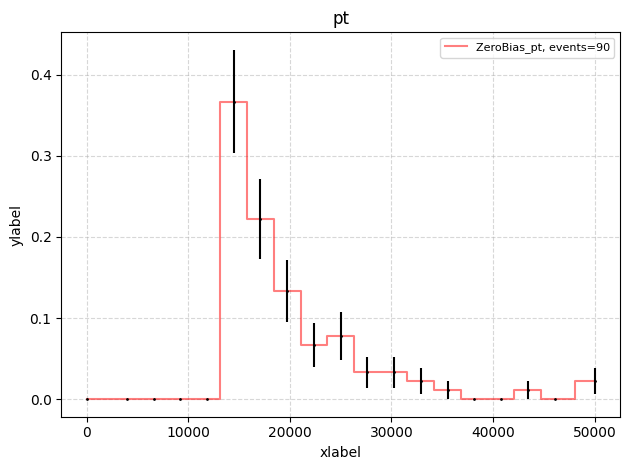

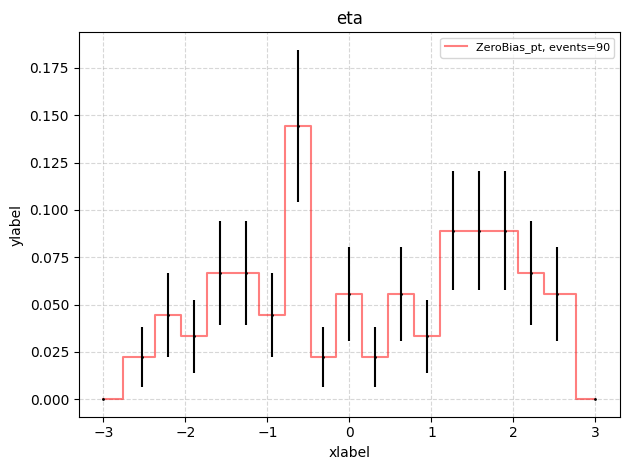

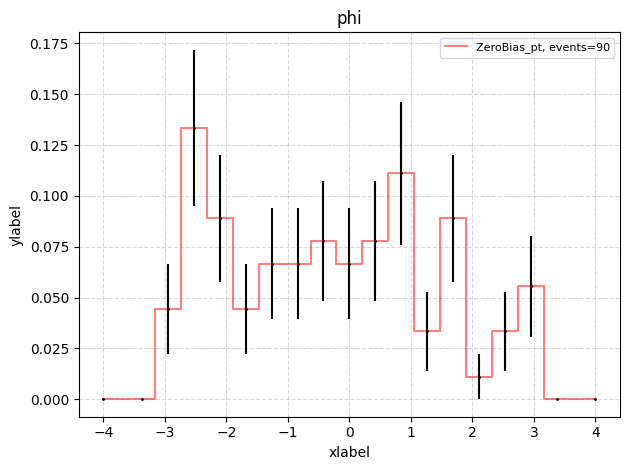

In [36]:
l=len(ZeroBias_pt_total[ak.num(ZeroBias_pt_total) > 0])
coolplot([ZeroBias_pt_total], np.linspace(0,5*10**4,20), labels=[f"ZeroBias_pt, events={l}"], title="pt")
coolplot([ZeroBias_eta_total], np.linspace(-3,3,20), labels=[f"ZeroBias_pt, events={l}"], title="eta")
coolplot([ZeroBias_phi_total], np.linspace(-4,4,20), labels=[f"ZeroBias_pt, events={l}"], title="phi")

In [37]:
len(iso_total[ak.num(iso_total) > 0])

1

In [38]:
iso_total=iso_total[~np.isnan(iso_total)]
iso_total[ak.num(iso_total) > 0]

<Array [[1.27e+04]] type='1 * var * float64'>

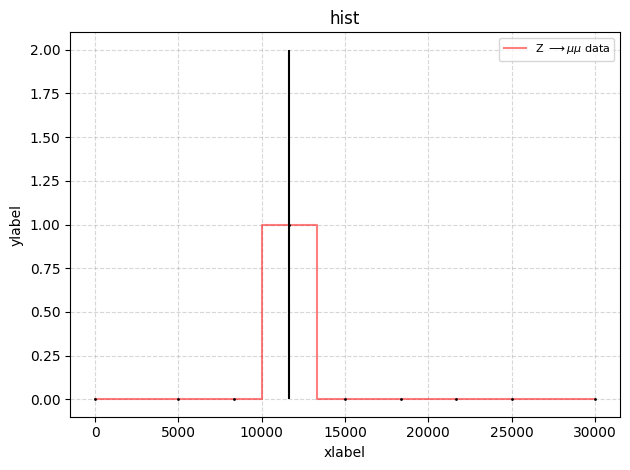

In [39]:
coolplot([iso_total], bins=np.linspace(0,30000,10))

In [ ]:

#Open ROOT file with uproot--------------------------------------------------------------------------------------------
file= uproot.open("/home/ruben/Escritorio/BachelorThesisRuben/Data/Muon_trees.root") 

#Get trees-------------------------------------------------------------------------------------------------------------
MuonTree_ZeroBias=file["MuonTree_ZeroBias;1"]
MuonTree_Zmumu=file["MuonTree_Zmumu;1"]

#Get data from trees---------------------------------------------------------------------------------------------------
#Z -> mu mu
Zmumu_pt  = MuonTree_Zmumu["muon_pt"].array()
Zmumu_eta = MuonTree_Zmumu["muon_eta"].array()
Zmumu_phi = MuonTree_Zmumu["muon_phi"].array()
#Zero Bias
ZeroBias_pt  = MuonTree_ZeroBias["muon_pt"].array()
ZeroBias_eta = MuonTree_ZeroBias["muon_eta"].array()
ZeroBias_phi = MuonTree_ZeroBias["muon_phi"].array()

Zbl1_pt = MuonTree_ZeroBias["LVL1Muon_et"].array() * 1000
Zbl1_eta = MuonTree_ZeroBias["LVL1Muon_eta"].array()
Zbl1_phi = MuonTree_ZeroBias["LVL1Muon_phi"].array()
#Pre-select data-------------------------------------------------------------------------------------------------------
#Chose event range
#Z -> mu mu range
nmin1=0
nmax1=1000
#Zero Bias range
nmin2=0
nmax2=200000
#Select quality 0 Z->mumu
Zmumu_pt=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_pt"].array(),0)[nmin1:nmax1]
Zmumu_eta=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_eta"].array(),0)[nmin1:nmax1]
Zmumu_phi=quality_selector_with_empty(MuonTree_Zmumu["muon_quality"].array(),MuonTree_Zmumu["muon_phi"].array(),0)[nmin1:nmax1]
#Select the Z peak pairs
Zmumu_pt, Zmumu_eta, Zmumu_phi= get_all_Z_peak_pairs(Zmumu_pt,Zmumu_eta,Zmumu_phi)

#Select ZeroBias
ZeroBias_pt=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_pt"].array())[nmin2:nmax2]
ZeroBias_eta=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_eta"].array())[nmin2:nmax2]
ZeroBias_phi=energy_cut_with_empty(MuonTree_ZeroBias["muon_pt"].array(), MuonTree_ZeroBias["muon_phi"].array())[nmin2:nmax2]

#Select LVL1 ZeroBias
e_cut= 14000
mask =Zbl1_pt >= e_cut

Zbl1_pt=(Zbl1_pt[mask])[nmin2:nmax2]
Zbl1_eta=(Zbl1_eta[mask])[nmin2:nmax2]
Zbl1_phi=(Zbl1_phi[mask])[nmin2:nmax2]

#Compute matchings
mask = offline_LVL1_matcher(ZeroBias_eta, ZeroBias_phi, Zbl1_eta, Zbl1_phi)

#Apply them
ZeroBias_pt=ZeroBias_pt[mask]
ZeroBias_eta=ZeroBias_eta[mask]
ZeroBias_phi=ZeroBias_phi[mask]


100%|██████████| 1000/1000 [00:01<00:00, 761.22it/s]
